# Data Statistics
data from neuropixels recordings

In [25]:
# imports 
import numpy as np 
import pandas as pd 
import h5py
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from pathlib import Path
from matplotlib_venn import venn3
import matplotlib.colors as mcolors
import warnings
import pingouin as pg
from sklearn.linear_model import LinearRegression
import seaborn as sns
import os
import glob

warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)

In [26]:
# functions
def get_labelled_posteriors(indata, labels):

    '''
    INPUTS:
    indata = posterior probabilites from a classifier with the shape
            n_trials x n_timesteps x n_classes
        
    labels = 1d array with len(n_trials) - these labels ought
            to correspond to class numbers (layers in indata)

    OUTPUT:
        labelled_posteriors = posterior probabilities associated with the
        classes in the labels input for each timestep and trial
    '''

    n_trials, n_times, n_classes = indata.shape
    class_lbls = np.unique(labels)
    class_lbls = class_lbls[~np.isnan(class_lbls)]

    # initialize output
    labelled_posteriors = np.zeros(shape = (n_trials, n_times))

    for ix, lbl in enumerate(class_lbls):
        
        # find trials where this label was chosen
        labelled_posteriors[labels == lbl,:] = indata[labels == lbl,:,int(ix)]
        
    return labelled_posteriors


def pull_balanced_train_set(trials2balance, params2balance):
    '''
    INPUTS:
    trials2balance   - ***logical array*** of the trials you want to balance
    params2balance   - ***list*** where each element is a vector of categorical
                        parameters to balance (e.g. choice value and side)
                        each element of params2balance must have the same
                        number of elements as trials2balance
    OUTPUTS:
    train_ix         - trial indices of a fully balanced training set
    leftover_ix      - trial indices of trials not included in train_ix
    '''

    # Find the indices where trials are selected to balance
    balance_indices = np.where(trials2balance)[0]

    # Create an array of parameters to balance
    params_array = np.array(params2balance).T

    # Find unique combinations and their counts
    p_combos, p_counts = np.unique(params_array[balance_indices], axis=0, return_counts=True)

    # Determine the minimum count for a balanced set
    n_to_keep = np.min(p_counts)

    # Initialize arrays to mark selected and leftover trials
    train_ix = np.zeros(len(trials2balance), dtype=bool)
    leftover_ix = np.zeros(len(trials2balance), dtype=bool)

    # Select a balanced number of trials for each unique parameter combination
    for combo in p_combos:
        # Find indices of trials corresponding to the current combination
        combo_indices = np.where((params_array == combo).all(axis=1) & trials2balance)[0]

        # Shuffle the indices
        np.random.shuffle(combo_indices)

        # Select n_to_keep trials and mark them as part of the training set
        train_ix[combo_indices[:n_to_keep]] = True

        # Mark the remaining trials as leftovers
        leftover_ix[combo_indices[n_to_keep:]] = True

    return train_ix, leftover_ix


def random_prop_of_array(inarray, proportion):
    '''
    INPUTS
    inarray = logical/boolean array of indices to potentially use later
    proportion = how much of inarray should randomly be selected

    OUTPUT
    out_array = logical/boolean that's set as 'true' for a proportion of the 
                initial 'true' values in inarray
    '''

    out_array = np.zeros(shape = (len(inarray), ))

    # find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())

    # keep only a proportion of that array
    kept_ix = shuffled_ixs[0: round(len(shuffled_ixs)*proportion)]

    # fill in the kept indices
    out_array[kept_ix] = 1

    # make this a logical/boolean
    out_array = out_array > 0

    return out_array

def find_h5_files(directory):
    """
    Search for HDF5 files (.h5 extension) in the specified directory.

    Parameters:
    - directory (str): Path to the directory to search for HDF5 files.

    Returns:
    - List[str]: A list of filenames (including paths) of HDF5 files found in the directory.
    """
    h5_files = []
    search_pattern = os.path.join(directory, '*.h5')  # Pattern to search for .h5 files

    for file_path in glob.glob(search_pattern):
        if os.path.isfile(file_path):
            h5_files.append(file_path)

    return h5_files

def pull_from_h5(file_path, data_to_extract):
    try:
        with h5py.File(file_path, 'r') as file:
            # Check if the data_to_extract exists in the HDF5 file
            if data_to_extract in file:
                data = file[data_to_extract][...]  # Extract the data
                return data
            else:
                print(f"'{data_to_extract}' not found in the file.")
                return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
def list_hdf5_data(file_path):
    try:
        with h5py.File(file_path, 'r') as file:
            print(f"Datasets in '{file_path}':")
            for dataset in file:
                print(dataset)
    except Exception as e:
        print(f"An error occurred: {e}")


def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val


def get_ch_and_unch_pps(in_pp, bhv, ch_val, unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        ch_val (ndarray): vector indicating the class that is ultimately chosen
        unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        ch_pp (ndarray): vector of the postior at each point in time for each trial's chosen option
        unch_pp (ndarray): vector of the postior at each point in time for each trial's unchosen option
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    ch_pp = np.zeros(shape=(n_trials, n_times))
    unch_pp = np.zeros(shape=(n_trials, n_times))

    # loop over each trial
    for t in range(n_trials):
        
        # get the chosen and unchosen PPs
        ch_pp[t, :] = in_pp[t, :, int(ch_val[t]-1)]
        unch_pp[t, :] = in_pp[t, :, int(unch_val[t]-1)]
        
    # set the forced choice unchosen pps to nans, since there was only 1 option
    unch_pp[bhv['forced'] == 1, :] = np.nan
    
    return ch_pp, unch_pp


def get_alt_ch_and_unch_pps(in_pp, bhv, s_ch_val, s_unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        s_ch_val (ndarray): vector indicating the class that is ultimately chosen
        s_unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        alt_ch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
        alt_unch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    alt_ch_pp = np.zeros(shape=(n_trials, n_times))
    alt_unch_pp = np.zeros(shape=(n_trials, n_times))

    alt_ch_val = np.zeros_like(s_ch_val)
    alt_unch_val = np.zeros_like(s_unch_val)
    
    alt_ch_val[bhv['state'] == 1] = 8 - s_ch_val[bhv['state'] == 1] + 1
    alt_ch_val[bhv['state'] == 2] = 8 - s_ch_val[bhv['state'] == 2] + 1

    alt_unch_val[bhv['state'] == 1] = 8 - s_unch_val[bhv['state'] == 1] + 1
    alt_unch_val[bhv['state'] == 2] = 8 - s_unch_val[bhv['state'] == 2] + 1

    for t in range(n_trials):
        
        alt_ch_pp[t, :] = in_pp[t, :, int(alt_ch_val[t]-1)]
        alt_unch_pp[t, :] = in_pp[t, :, int(alt_unch_val[t]-1)]

    # set the alternative values to nans for state 3, since there were no alternatives
    alt_ch_pp[bhv['state'] == 3] = np.nan
    alt_unch_pp[bhv['state'] == 3] = np.nan

    return alt_ch_pp, alt_unch_pp

def find_candidate_states(indata, n_classes, temporal_thresh, mag_thresh):
    """Finds periods where decoded posteriors are twice their noise level.

    Args:
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.
        n_classes (int): How many classes were used in the decoder?
        temporal_thresh (int): Number of contiguous samples that must be above a threshold to be a real state (typically 2).
        mag_thresh (flat): how many times the noise level must a state be? (e.g. 2 = twice the noise level)

    Returns:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length].
        state_array (ndarray): 2d array the same size as indata. It contains 1 in all locations where there were states and 0s everywhere else.
    """
    state_details = np.array([])
    state_array = np.zeros_like(indata)
    
    state_magnitude_thresh = (1 / n_classes) * mag_thresh

    for t in range(indata.shape[0]):
        state_len, state_pos, state_type = find_1dsequences(indata[t, :] > state_magnitude_thresh)
        state_len = state_len[state_type == True]
        state_pos = state_pos[state_type == True]

        for i in range(len(state_len)):
            state_details = np.concatenate((state_details, np.array([t, state_pos[i], state_len[i]])))

    state_details = state_details.reshape(-1, 3)
    state_details = state_details[state_details[:, 2] > temporal_thresh, :]

    # Update state_array using state_details information
    for j in range(len(state_details)):
        state_trial, state_start, state_len = state_details[j].astype(int)
        state_array[state_trial, state_start:(state_start + state_len)] = 1

    return state_details, state_array

def moving_average(x, w, axis=0):
    '''
    Moving average function that operates along specified dimensions of a NumPy array.

    Parameters:
    - x (numpy.ndarray): Input array.
    - w (int): Size of the window to convolve the array with (i.e., smoothness factor).
    - axis (int): Axis along which to perform the moving average (default is 0).

    Returns:
    - numpy.ndarray: Smoothed array along the specified axis with the same size as the input array.
    '''
    x = np.asarray(x)  # Ensure input is a NumPy array
    if np.isnan(x).any():
        x = np.nan_to_num(x)  # Replace NaN values with zeros

    if axis < 0:
        axis += x.ndim  # Adjust negative axis value

    kernel = np.ones(w) / w  # Create kernel for moving average

    # Pad the array before applying convolution
    pad_width = [(0, 0)] * x.ndim  # Initialize padding for each axis
    pad_width[axis] = (w - 1, 0)  # Pad along the specified axis (left side)
    x_padded = np.pad(x, pad_width, mode='constant', constant_values=0)

    # Apply 1D convolution along the specified axis on the padded array
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis, x_padded)

def find_1dsequences(inarray):
        ''' 
        run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) 
        '''
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]                 # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)     # must include last element 
            lens = np.diff(np.append(-1, i))      # run lengths
            pos = np.cumsum(np.append(0, lens))[:-1] # positions
            return(lens, pos, ia[i])
        
        
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
            bootstrap_means[:, col] = np.mean(bootstrap_samples, axis=1)

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.mean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.mean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval


In [27]:
datadir = r"D:\Projects\rotation_project\reprocessed_data"
data_files = find_h5_files(datadir)

In [28]:
data_files

['D:\\Projects\\rotation_project\\reprocessed_data\\D20231212_Rec03.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231214_Rec04.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231219_Rec05.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231221_Rec06.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231224_Rec07.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231227_Rec08.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231229_Rec09.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20240130_stimRec01.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\K20240625_Rec03.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\K20240628_Rec04.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\K20240701_Rec05.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\K20240707_Rec06.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\K20240710_Rec07.h5',
 'D:\\Projects\\rotation_project\\reprocessed_d

In [29]:
file_path = 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231219_Rec05.h5'

In [30]:
# access the data for this session
firing_rates = np.concatenate([pull_from_h5(file_path, 'CdN_zFR'), 
                               pull_from_h5(file_path, 'OFC_zFR')], axis=2)

u_names = np.concatenate([pull_from_h5(file_path, 'CdN_u_names'), 
                          pull_from_h5(file_path, 'OFC_u_names')], axis=0)

n_CdN = pull_from_h5(file_path, 'CdN_zFR').shape[2]
n_OFC = pull_from_h5(file_path, 'OFC_zFR').shape[2]
brain_areas = np.concatenate([np.zeros(shape=n_CdN, ), np.ones(shape=n_OFC, )]).astype(int)

u_locations = np.concatenate([pull_from_h5(file_path, 'CdN_locations'), 
                              pull_from_h5(file_path, 'OFC_locations')], axis=0)

ts = pull_from_h5(file_path, 'ts')
bhv = pd.read_hdf(file_path, key='bhv')

if len(bhv) > len(firing_rates):
    bhv = bhv.loc[0 :len(firing_rates)-1]

# subselect trials with a response that was correct
trials2keep = (bhv['n_sacc'] > 0)
bhv = bhv.loc[trials2keep]
firing_rates = firing_rates[trials2keep, :,:]
firing_rates = np.nan_to_num(firing_rates, nan=0)

n_trials, n_times, n_units = np.shape(firing_rates)

In [51]:
print("firing_rates shape:", firing_rates.shape)  # (n_trials, n_times, n_units)
print("bhv shape:", bhv.shape)
print("Number of CdN units:", n_CdN)
print("Number of OFC units:", n_OFC)

firing_rates shape: (808, 81, 787)
bhv shape: (808, 31)
Number of CdN units: 403
Number of OFC units: 384


In [52]:
bhv.columns

Index(['Unnamed: 0', 'fname', 'tnum', 'use', 'state', 'state_cue', 'forced',
       'l_val', 'r_val', 'ch_val', 'picked_best', 'rt', 'side', 'cue_on_t_npx',
       'pics_on_t_npx', 'n_sacc', 'sacc1_t', 'sacc1_val', 'sacc1_side',
       'sacc2_t', 'sacc2_val', 'sacc2_side', 'sacc3_t', 'sacc3_val',
       'sacc3_side', 'sacc4_t', 'sacc4_val', 'sacc4_side', 'sacc5_t',
       'sacc5_val', 'sacc5_side'],
      dtype='object')

In [53]:
bhv.head()

,Unnamed: 0,fname,tnum,use,state,state_cue,forced,l_val,r_val,ch_val,...,sacc2_side,sacc3_t,sacc3_val,sacc3_side,sacc4_t,sacc4_val,sacc4_side,sacc5_t,sacc5_val,sacc5_side
0,0,D20231219,0.0,1.0,3.0,1.0,0.0,1.0,3.0,3.0,...,0.0,264.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,D20231219,1.0,1.0,1.0,2.0,1.0,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,D20231219,2.0,1.0,2.0,1.0,0.0,2.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,D20231219,3.0,1.0,1.0,2.0,0.0,2.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,D20231219,4.0,1.0,1.0,2.0,0.0,2.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Select trials with exactly one saccade
single_saccade_mask = bhv['n_sacc'] == 1
bhv_single = bhv[single_saccade_mask]
firing_single = firing_rates[single_saccade_mask.values, :, :]

# Average firing rate across time for each trial and neuron
# Resulting shape: (n_trials, n_units)
mean_FR = firing_single.mean(axis=1)

# Extract chosen value
chosen_value = bhv_single['ch_val'].values.reshape(-1, 1)

In [39]:
import statsmodels.api as sm

df = pd.DataFrame({
    'value': bhv_single['ch_val'].values,
    'state': bhv_single['state'].values
})

state_dummies = pd.get_dummies(df['state'].astype(int), prefix='state')
df = pd.concat([df, state_dummies], axis=1)

df['value_state_1'] = df['value'] * df['state_1']
df['value_state_2'] = df['value'] * df['state_2']
df['value_state_3'] = df['value'] * df['state_3']

X = df[['value', 'state_1', 'state_2', 'state_3',
            'value_state_1', 'value_state_2', 'value_state_3']]

X[['state_1', 'state_2', 'state_3']] = X[['state_1', 'state_2', 'state_3']].astype(int)
X = sm.add_constant(X)  # Add intercept term
  
value_betas = []
value_pvals = []

for i in range(n_units):
    y = mean_FR[:, i]
    
    model = sm.OLS(y, X).fit()
    value_betas.append(model.params['value'])
    value_pvals.append(model.pvalues['value'])

neuron_profile = pd.DataFrame({
    'neuron': u_names, 
    'brain_area': brain_areas,
    'lateral': lateral,
    'depth': depth,
    'value_beta': value_betas,
    'value_pval': value_pvals
})


C:\Users\krgyk\AppData\Local\Temp\ipykernel_644\2910436298.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['state_1', 'state_2', 'state_3']] = X[['state_1', 'state_2', 'state_3']].astype(int)


In [40]:
neuron_profile.head()

,neuron,brain_area,lateral,depth,value_beta,value_pval
0,b'D20231219_Rec05_CdN_u0',0,-18.178385,4.338798,0.071862,9.145796e-16
1,b'D20231219_Rec05_CdN_u1',0,-16.471363,-4.351123,0.030736,9.033968e-06
2,b'D20231219_Rec05_CdN_u2',0,-19.832074,7.895096,-0.006998,4.851968e-01
3,b'D20231219_Rec05_CdN_u5',0,102.174930,27.829872,-0.025555,8.510612e-03
4,b'D20231219_Rec05_CdN_u7',0,90.094397,22.415336,-0.152522,2.648503e-56


In [41]:
# define significance thresholds
sig_thresh = 0.05
beta_thresh = 1e-3  # to exclude near-zero betas

value_neurons = neuron_profile[
    (neuron_profile['value_pval'] < sig_thresh) &
    (neuron_profile['value_beta'].abs() > beta_thresh)
].copy()

# Use 1 for positive encoding, 0 for negative encoding
value_neurons['encoding_sign'] = (value_neurons['value_beta'] > 0).astype(int)


In [42]:
neuron_profile.shape

(787, 6)

In [43]:
value_neurons.shape

(453, 7)

In [44]:
value_neurons.head()

,neuron,brain_area,lateral,depth,value_beta,value_pval,encoding_sign
0,b'D20231219_Rec05_CdN_u0',0,-18.178385,4.338798,0.071862,9.145796e-16,1
1,b'D20231219_Rec05_CdN_u1',0,-16.471363,-4.351123,0.030736,9.033968e-06,1
3,b'D20231219_Rec05_CdN_u5',0,102.174930,27.829872,-0.025555,8.510612e-03,0
4,b'D20231219_Rec05_CdN_u7',0,90.094397,22.415336,-0.152522,2.648503e-56,0
5,b'D20231219_Rec05_CdN_u8',0,109.631377,17.874801,0.037382,2.379013e-02,1


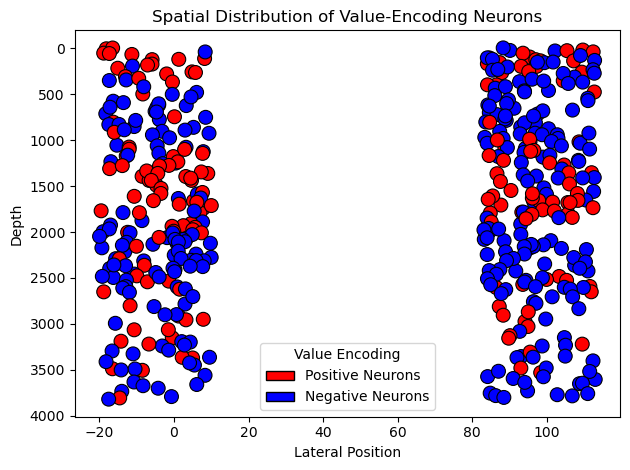

In [45]:
from matplotlib.patches import Patch


scatter = sns.scatterplot(
    data=value_neurons,
    x='lateral',
    y='depth',
    hue='encoding_sign',
    palette={1: 'red', 0: 'blue'},
    s=100,
    edgecolor='black'
)

plt.title('Spatial Distribution of Value-Encoding Neurons')
plt.xlabel('Lateral Position')
plt.ylabel('Depth')
plt.gca().invert_yaxis()  # optional: match anatomical orientation
plt.legend(title='Value Encoding')

legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Positive Neurons'),
    Patch(facecolor='blue', edgecolor='black', label='Negative Neurons')
]
plt.legend(handles=legend_elements, title='Value Encoding', loc='best')


plt.tight_layout()
plt.show()

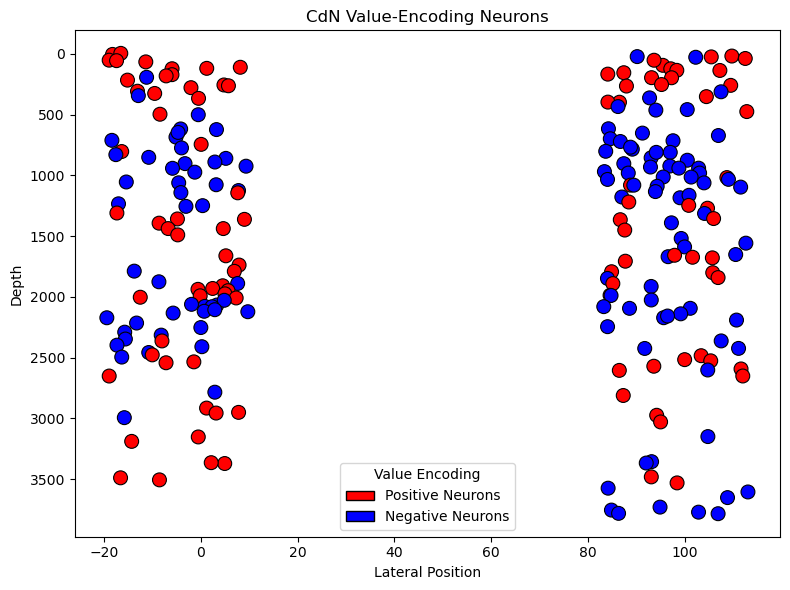

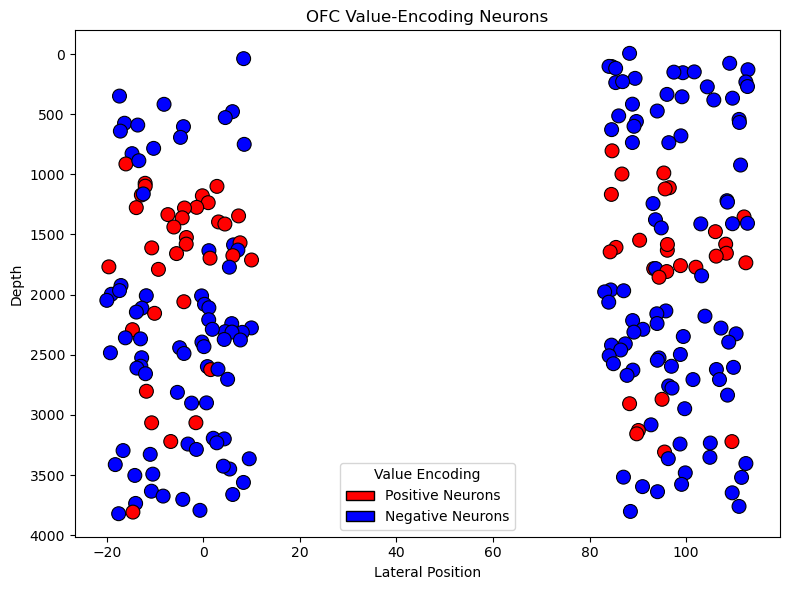

In [46]:
encoding_palette = {1: 'red', 0: 'blue'}

# Filter data by brain area
cdn_neurons = value_neurons[value_neurons['brain_area'] == 0]
ofc_neurons = value_neurons[value_neurons['brain_area'] == 1]

# Custom legend
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Positive Neurons'),
    Patch(facecolor='blue', edgecolor='black', label='Negative Neurons')
]

# --- Plot for CdN ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=cdn_neurons,
    x='lateral',
    y='depth',
    hue='encoding_sign',
    palette=encoding_palette,
    s=100,
    edgecolor='black'
)
plt.gca().invert_yaxis()
plt.xlabel('Lateral Position')
plt.ylabel('Depth')
plt.title('CdN Value-Encoding Neurons')
plt.legend(handles=legend_elements, title='Value Encoding')
plt.tight_layout()
plt.show()

# --- Plot for OFC ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=ofc_neurons,
    x='lateral',
    y='depth',
    hue='encoding_sign',
    palette=encoding_palette,
    s=100,
    edgecolor='black'
)
plt.gca().invert_yaxis()
plt.xlabel('Lateral Position')
plt.ylabel('Depth')
plt.title('OFC Value-Encoding Neurons')
plt.legend(handles=legend_elements, title='Value Encoding')
plt.tight_layout()
plt.show()


In [47]:
# Define your data directory and file list
datadir = r"D:\Projects\rotation_project\reprocessed_data"
data_files = find_h5_files(datadir)
data_files

['D:\\Projects\\rotation_project\\reprocessed_data\\D20231212_Rec03.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231214_Rec04.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231219_Rec05.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231221_Rec06.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231224_Rec07.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231227_Rec08.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20231229_Rec09.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\D20240130_stimRec01.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\K20240625_Rec03.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\K20240628_Rec04.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\K20240701_Rec05.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\K20240707_Rec06.h5',
 'D:\\Projects\\rotation_project\\reprocessed_data\\K20240710_Rec07.h5',
 'D:\\Projects\\rotation_project\\reprocessed_d

In [48]:
datadir = r"D:\Projects\rotation_project\reprocessed_data"
data_files = find_h5_files(datadir)